In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from numpy import mean
from numpy import std
from scipy.stats import sem

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
#wczytanie danych
transfusion_data = pd.read_csv("transfusion.data")

In [3]:
#analiza struktury danych
transfusion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [4]:
#analiza wartości danych
transfusion_data.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


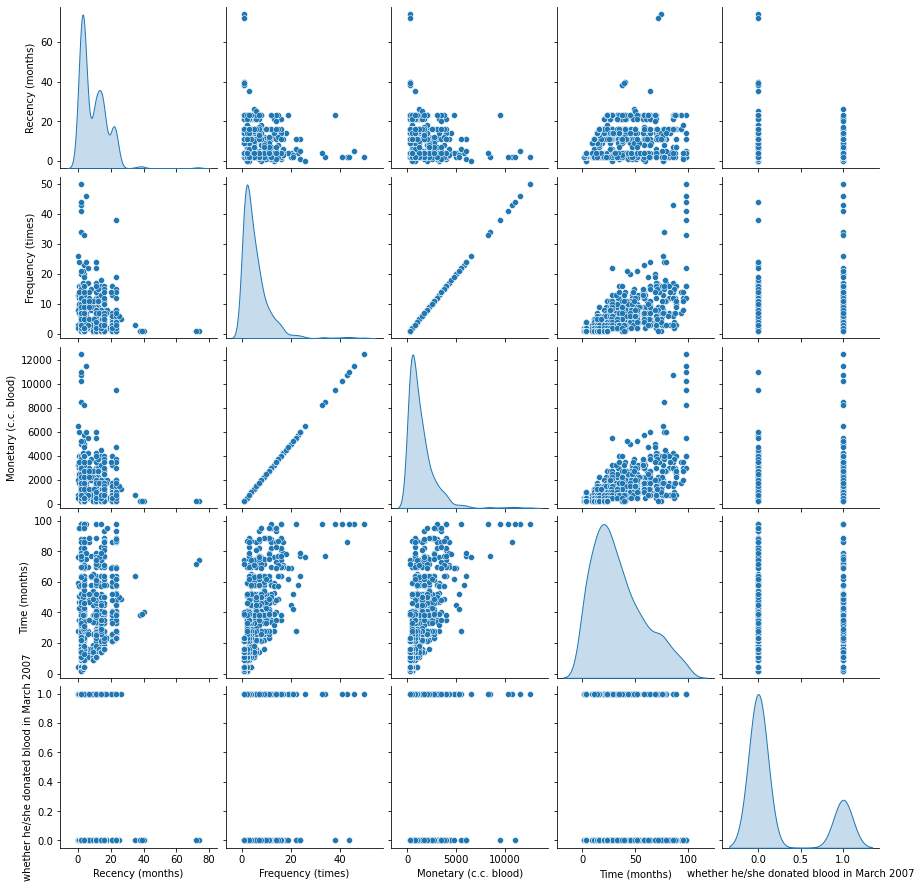

In [5]:
sb.pairplot(transfusion_data, diag_kind="kde")

In [6]:
transfusion_data.rename(
    columns={'Recency (months)': 'recency', 'Frequency (times)': 'frequency', 'Monetary (c.c. blood)': 'monetary', 'Time (months)': 'time', 'whether he/she donated blood in March 2007': 'label'},
    inplace=True
)

In [7]:
#analiza balansu danych - stosunku poszczególnych klas w całym zbiorze
transfusion_data.label.value_counts(normalize=True)

0    0.762032
1    0.237968
Name: label, dtype: float64

In [8]:
#podział na zbiór pełny oraz pozbawiony cechy Monetary silnie dodatnio skorelowanej z cechą Frequency
transfusion_data_reduced = transfusion_data
transfusion_data_reduced.drop(columns=['monetary'])

,recency,frequency,time,label
0,2,50,98,1
1,0,13,28,1
2,1,16,35,1
3,2,20,45,1
4,1,24,77,0
...,...,...,...,...
743,23,2,38,0
744,21,2,52,0
745,23,3,62,0
746,39,1,39,0


In [9]:
X = transfusion_data.copy().drop(columns=['label'])
Xr = transfusion_data_reduced.copy().drop(columns=['label'])

Y = transfusion_data.label
Yr = transfusion_data_reduced.label

In [10]:
X[0:5]

,recency,frequency,monetary,time
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


In [11]:
Xr[50:55]

,recency,frequency,monetary,time
50,2,11,2750,46
51,2,11,2750,46
52,2,6,1500,22
53,2,12,3000,52
54,4,5,1250,14


In [25]:
#podział danych na zbiory testowe i treningowe
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=17,
    stratify=Y
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr,
    Yr,
    test_size=0.25,
    random_state=17,
    stratify=Yr
)

In [26]:
#trening modelu
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train, y_train)

acc = accuracy_score(y_test, logistic_regression.predict(X_test))
print("Model accuracy is {0:0.6f}".format(acc))

Model accuracy is 0.754011


In [27]:
conf_matrix = confusion_matrix(y_test, logistic_regression.predict(X_test))
print(conf_matrix)

[[135   7]
 [ 39   6]]


In [28]:
logistic_regression_r = LogisticRegression()

logistic_regression_r.fit(Xr_train, yr_train)

acc = accuracy_score(yr_test, logistic_regression_r.predict(Xr_test))
print("Model accuracy is {0:0.6f}".format(acc))

Model accuracy is 0.754011


In [29]:
conf_matrix = confusion_matrix(yr_test, logistic_regression_r.predict(Xr_test))
print(conf_matrix)

[[135   7]
 [ 39   6]]


In [30]:
#porównanie z modelem RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=700, random_state=101)

random_forest.fit(Xr_train, yr_train)

acc = accuracy_score(yr_test, random_forest.predict(Xr_test))
print("Model accuracy is {0:0.6f}".format(acc))

Model accuracy is 0.732620


In [33]:
#GridSearch w celu znalezienia optymalnych parametrów dla modelu

max_iter = np.arange(50,1001, 50).tolist()
parameters=[{'solver':['newton-cg', 'lbfgs', 'liblinear','sag', 'saga'], 'max_iter':max_iter}]
model = GridSearchCV(LogisticRegression(), parameters, cv=10)
model.fit(Xr,Yr)
print(model.best_params_)
model.best_estimator_

H:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
H:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

{'max_iter': 950, 'solver': 'sag'}


H:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
H:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
H:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
H:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
H:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter w

LogisticRegression(max_iter=950, solver='sag')

In [34]:
best_linear_regression = LogisticRegression(max_iter=950, solver='sag')

best_linear_regression.fit(Xr_train, yr_train)

acc = accuracy_score(yr_test, best_linear_regression.predict(Xr_test))
print("Model accuracy is {0:0.6f}".format(acc))

Model accuracy is 0.807487


H:\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [35]:
conf_matrix = confusion_matrix(yr_test, best_linear_regression.predict(Xr_test))
print(conf_matrix)

[[138   4]
 [ 32  13]]
